In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pywt

from scipy.spatial.distance import pdist

import mne
from mne.datasets.sleep_physionet.age import fetch_data

In [4]:
# Define the list of subjects (assuming subject IDs 0 to 19)
subject_ids = range(20)

# Dictionary mapping sleep stages to event IDs
annotation_desc_2_event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
}

# List to store epochs from all subjects
all_raw_data = []
all_events_train = []
event_offset = 0

for subject in subject_ids:
    # Fetch data for the current subject
    [subject_files] = fetch_data(subjects=[subject], recording=[1])
    
    # Read raw data
    raw_train = mne.io.read_raw_edf(
        subject_files[0],
        stim_channel="Event marker",
        infer_types=True,
        preload=True,
        verbose="error"
    )
    
    # Read annotations
    annot_train = mne.read_annotations(subject_files[1])
    
    # Set annotations to raw data
    raw_train.set_annotations(annot_train, emit_warning=False)
    
    # Crop annotations (keep last 30-min wake events before sleep and first 30-min wake events after sleep)
    annot_train.crop(annot_train[1]["onset"] - 30 * 60, annot_train[-2]["onset"] + 30 * 60)
    raw_train.set_annotations(annot_train, emit_warning=False)
    
    # Extract events from annotations
    events_train, _ = mne.events_from_annotations(
        raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0
    )
    
    # Adjust event times by adding an offset
    events_train[:, 0] += event_offset
    
    # Update event_offset based on the duration of the current raw data
    event_offset += raw_train.n_times
    
    all_raw_data.append(raw_train)
    all_events_train.append(events_train)
    
    
# Concatenate all raw data
all_raw_data = mne.concatenate_raws(all_raw_data)

# Combine all events
all_events_train = np.concatenate(all_events_train, axis=0)

# Create a new event_id that unifies stages 3 and 4
event_id = {
        "Sleep stage W": 1,
        "Sleep stage 1": 2,
        "Sleep stage 2": 3,
        "Sleep stage 3/4": 4,
        "Sleep stage R": 5,
        }
    
# Define tmax for epochs
tmax = 30.0 - 1.0 / all_raw_data.info["sfreq"]  # tmax is inclusive
    
# Create epochs
epochs = mne.Epochs(
        raw=all_raw_data,
        events=all_events_train,
        event_id=event_id,
        tmin=0.0,
        tmax=tmax,
        baseline=None,
    )
    
# Delete raw_train to free up memory (optional)
del all_raw_data 

Using default location ~/mne_data for PHYSIONET_SLEEP...


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 

In [5]:
def multiscale_sample_entropy(x, m=2, r=0.15, tau=1):
    """
    Multiscale Sample Entropy
    """

    # Coarse signal
    y = np.mean(np.reshape(x[:len(x) // tau * tau], (tau, -1)), axis=0)
    
    # (m+1)-element sequences
    X = np.array([y[i:i + m + 1] for i in range(len(y) - m)])
    
    # Matching (m+1)-element sequences
    chebyshev_dist = pdist(X, metric='chebyshev')
    A = np.sum(chebyshev_dist < r * np.nanstd(x, ddof=1))
    
    # Matching m-element sequences
    X = X[:, :-1]
    chebyshev_dist = pdist(X, metric='chebyshev')
    B = np.sum(chebyshev_dist < r * np.nanstd(x, ddof=1))
    
    # Take log
    if A == 0 or B == 0:
        return np.nan
    
    e = np.log(B / A)
    
    return e

/var/folders/60/rtsk3nq12cz6nl91fvnky3wr0000gp/T/ipykernel_73124/2924164052.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=['W', 'N1', 'N2', 'N3/N4', 'REM'])


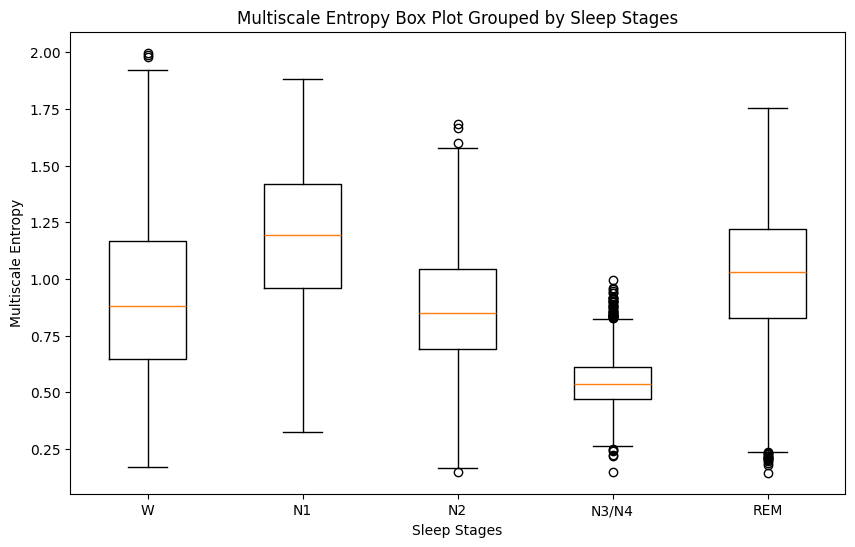

In [14]:
# Calculate MSE for each epoch and handle potential NaN values
mse_values = []
for i, epoch in enumerate(epochs):
    mse = multiscale_sample_entropy(epoch[0, :], m=2, r=0.2)  # [0, :] to access the first channel
    if not np.isnan(mse):  # Ignore NaN values
        mse_values.append(mse)


# Create a dictionary to hold MSE values for each sleep stage
mse_by_stage = {label: [] for label in event_id.values()}

# Populate the dictionary with MSE values grouped by sleep stages
for label, mse in zip(epochs.events[:, 2], mse_values):
    mse_by_stage[label].append(mse)


# Sort the sleep stages by their labels to maintain the correct order
sorted_stages = sorted(mse_by_stage.keys())

# Prepare data for boxplot
boxplot_data = [mse_by_stage[stage] for stage in sorted_stages]

# Plotting
plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, labels=['W', 'N1', 'N2', 'N3/N4', 'REM'])
plt.title('Multiscale Entropy Box Plot Grouped by Sleep Stages')
plt.xlabel('Sleep Stages')
plt.ylabel('Multiscale Entropy')
plt.show()
